필요한 라이브러리 모듈 가져오기

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import multivariate_normal, permutation
import matplotlib.pyplot as plt
import pandas as pd 
from pandas import DataFrame, Series

난수 생성

In [2]:
np.random.seed(20180427)

확률이 0 인 난수 선언
* n : 난수의 갯수
* mu : n 차원 분포의 평균
* multivariate_normal(mean, cov[, size, check_valid, tol]) : 다변수 정규 분포에서 무작위로 샘플을 선언

In [3]:
n0 = 20 
mu0 = [10,11] 
variance0 = 20 

data0 = multivariate_normal(mu0, np.eye(2) * variance0, n0)
df0 = DataFrame(data0, columns=['x1','x2'])
df0['t']=0

확률이 1인 난수 선언

In [4]:
n1 = 15
mu1 = [18,20]
variance1 = 22

data1 = multivariate_normal(mu1, np.eye(2)*variance1, n1)
df1 = DataFrame(data1, columns=['x1','x2'])
df1['t'] = 1

확률이 0 ,1 인 난수를 하나의 DataFrame에 저장

In [5]:
df = pd.concat([df0,df1], ignore_index = True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)
train_set

,x1,x2,t
0,13.754760,6.206215,0
1,14.160872,11.479040,0
2,15.878563,19.072807,1
3,15.718922,18.768468,1
4,8.503453,21.703925,0
5,12.505810,17.218799,0
6,-2.193010,5.355987,0
7,7.679615,14.474577,0
8,14.027264,16.895398,1
9,12.155246,20.938471,1


생성된 학습 모델을 train_x, train_t에 행렬로 저장

In [6]:
train_x = train_set[['x1','x2']].as_matrix()
train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])  # [35,1] 행렬로 변환

**1단계 수식작성**  난수들이 분포된 영역의 확률이 1인 수식 작성
> * 수식에 의해 계산된 값을 sigmoid 함수를 통하여 값을 0~1 사이의 값(확률)으로 변경
> * Sigmoid 함수 관련 설명 : http://taewan.kim/post/sigmoid_diff/

In [7]:
# t = 1 인 확률을 구하는 식 
x = tf.placeholder(tf.float32,[None,2])
w = tf.Variable(tf.zeros([2,1]))
w0 = tf.Variable(tf.zeros([1]))

f = tf.matmul(x,w) + w0
p = tf.sigmoid(f)


**2단계 오차함수 작성**

In [8]:
t = tf.placeholder(tf.float32,[None,1])
costFunction = -tf.reduce_sum(t * tf.log(p) + (1-t)*tf.log(1-p))

**3단계 최적화 과정을 통해 파리미터 값을 결정**

In [9]:
#trainOptimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
trainOptimizer = tf.train.AdamOptimizer()
train = trainOptimizer.minimize(costFunction)

예측값과 정확도 구하는 식 선언
> * tf.sign(x)  x의 값에 따라 부호를 반환 음수 이면 -1, 0이면 0 양수이면 1 반환
> * tf.equal(x,y) x와 y 값이 같은지 bool 값 반환
> * tf.cast(x, dtype) 텐서 타입으로 형 변환 

In [10]:
prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

세션 정의 및 변수 초기화

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

20,000번의 학습 과정을 통하여 손실값 및 정확도 출력

In [12]:
itrNum = 0 
for _ in range(20000):
    itrNum += 1
    trainValue, costFunctionValue, accuracyValue = sess.run([train, costFunction, accuracy], feed_dict = {x:train_x, t:train_t})
    if (itrNum % 2000 == 0) :
        print ("Step : %d, cost(loss) : %f , accuracy : %f" %(itrNum, costFunctionValue, accuracyValue))
        

Step : 2000, cost(loss) : 16.837088 , accuracy : 0.914286
Step : 4000, cost(loss) : 12.956228 , accuracy : 0.914286
Step : 6000, cost(loss) : 10.605145 , accuracy : 0.914286
Step : 8000, cost(loss) : 9.106233 , accuracy : 0.885714
Step : 10000, cost(loss) : 8.134089 , accuracy : 0.885714
Step : 12000, cost(loss) : 7.503963 , accuracy : 0.885714
Step : 14000, cost(loss) : 7.101242 , accuracy : 0.885714
Step : 16000, cost(loss) : 6.852183 , accuracy : 0.914286
Step : 18000, cost(loss) : 6.708141 , accuracy : 0.914286
Step : 20000, cost(loss) : 6.635503 , accuracy : 0.914286


학습을 통해 결정된 w파라미터 값 확인

In [13]:
w0Value, wValue = sess.run([w0,w])

w0Value, w1Value, w2Value = w0Value[0], wValue[0][0], wValue[1][0]
print(w0Value, w1Value, w2Value)
print (wValue)

-15.21047 0.4421058 0.5526983
[[0.4421058]
 [0.5526983]]


학습 결과를 그래프로 표현

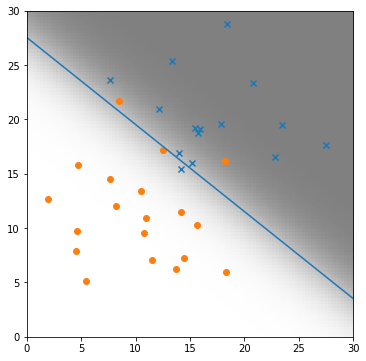

In [14]:
train_set0 = train_set[train_set['t']==0]
train_set1 = train_set[train_set['t']==1]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set0.x1, train_set0.x2, marker='o')

linex = np.linspace(0,30,10)
liney = - (w1Value*linex/w2Value + w0Value/w2Value)
subplot.plot(linex, liney)

field = [[(1 / (1 + np.exp(-(w0Value + w1Value*x1 + w2Value*x2))))
          for x1 in np.linspace(0,30,100)]
         for x2 in np.linspace(0,30,100)]
subplot.imshow(field, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)